# Classification using Hybrid Scattering Networks


### Notebook 6a: Wavelet Scattering Transform




### Install dependencies

In [1]:
# # @title Install dependencies

# # @markdown install kymatio and ismir23-kymatio-tools from source
# !pip install git+https://github.com/kymatio/kymatio.git # install kymatio v0.4-dev from source
# !pip install git+https://github.com/cyrusvahidi/ismir23-kymatio-tools.git # install helper library for this tutorial
# !pip install lightning # install pytorch lightning
# !pip install ipywidgets

## Import Dependencies

In [25]:
# @title Import Dependencies

import os
import torch
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm

import numpy as np

import lightning as pl
from lightning import LightningModule

from s1dt.data import FeatureExtractorSOL
from s1dt.plot import (
    plot_scalogram,
    extract_s2_scalogram,
    create_s2_gif,
    extract_jtfst_scalogram,
    create_jtfst_gif
)
from torch.utils.data import DataLoader

from torch.utils.data import Dataset
import numpy as np

from IPython.display import Audio, display
## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import gca
import librosa
from kymatio.torch import Scattering1D
from ipywidgets import HTML
from IPython.display import Image
import sys

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
sys.path.insert(0, './utils')

from utils_functions import *
from LWDED_audiodataset import LDEDAudioDataset
from train_utils import train_single_epoch, test_single_epoch, training_loop, plot_data_distribution

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    
/bin/sh: 1: sox: not found


In [4]:
#@title Check GPU Status
import subprocess

USE_GPU = True #@param {type:"boolean"}

def to_device(tensor: torch.tensor):
    """ Move a torch tensor to the current device
    """
    return tensor.cuda() if USE_GPU else tensor.cpu()

#!nvidia-smi
nvidiasmi_output = subprocess.run(['nvidia-smi', '-L'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(nvidiasmi_output)
print(f"Using device: {'GPU' if USE_GPU else 'CPU'}")

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-8878a889-5eb0-35b1-bad5-81cbfbf49357)

Using device: GPU


### Prepare Dataset

In [5]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'defect classification', '6a_hybrid_wavelet_scattering')
model_path = os.path.join(PROJECT_ROOT_DIR, "trained_models", 'defect classification', '6a_hybrid_wavelet_scattering')
scaler_path = os.path.join(PROJECT_ROOT_DIR, "saved_scalers", 'defect classification',  '6a_hybrid_wavelet_scattering')
os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
os.makedirs(scaler_path, exist_ok=True)

# Change to desirable location of the raw dataset
Multimodal_dataset_PATH = "/home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset"
Annotation_file_path = os.path.join(Multimodal_dataset_PATH, "Annotation")
Dataset_path = os.path.join(Multimodal_dataset_PATH, 'Dataset')
final_audio_directory = os.path.join(Multimodal_dataset_PATH, 'Dataset', "audio")
final_image_directory  = os.path.join(Multimodal_dataset_PATH, 'Dataset', "thermal_images")
              
## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

np.random.seed(0)

In [6]:
classes = ('Balling', 'Non-defective', 'Laser-off')

SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 20

### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- The duration for each frame is 0.1 seconds (100 ms)

In [7]:
# Read the data back from the HDF5 file into a new DataFrame
# Read the data back from the HDF5 file into a new DataFrame
df_audio_dataset = pd.read_hdf(os.path.join(Dataset_path, 'df_audio_dataset_with_annotations(raw_audio).h5'), key='df')

df_audio_dataset = df_audio_dataset.dropna(subset=['label_1'])

df_audio_dataset

,audio_name,image_name,experiment_number,label_1,label_2,label_3,rms_energy,amplitude_envelope_mean,amplitude_envelope_std,zero_crossing_rate,...,mfcc_8_mean,mfcc_8_std,mfcc_9_mean,mfcc_9_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std
0,Exp_17_1_10.wav,Exp_17_1_10.jpg,17_1,Non-defective,NaN,NaN,0.031746,0.038982,0.014304,0.064399,...,-1.955670,7.565694,6.784209,13.263989,-4.241771,7.623967,10.760045,6.365362,-4.255302,6.843529
1,Exp_17_1_9.wav,Exp_17_1_9.jpg,17_1,Non-defective,NaN,NaN,0.042696,0.046830,0.018378,0.048526,...,2.400870,8.425775,10.965203,9.471119,-3.135444,8.011312,13.603483,6.959040,-5.711248,7.241501
2,Exp_17_1_8.wav,Exp_17_1_8.jpg,17_1,Non-defective,NaN,NaN,0.035057,0.042734,0.011573,0.075737,...,1.150261,9.403788,14.162999,9.516252,-8.762444,7.957384,12.542859,4.588312,-11.905286,5.806112
3,Exp_17_1_7.wav,Exp_17_1_7.jpg,17_1,Non-defective,NaN,NaN,0.030621,0.034609,0.014976,0.087528,...,-1.952435,7.164872,11.940722,13.199364,-8.201095,7.420465,10.894137,8.839649,-8.552934,7.470698
4,Exp_17_1_6.wav,Exp_17_1_6.jpg,17_1,Non-defective,NaN,NaN,0.029938,0.039680,0.008860,0.091837,...,-2.629555,10.869521,10.822444,7.406270,-7.824436,7.594238,11.877039,7.440609,-7.672489,7.914073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6812,Exp_April_16_test_4_4.wav,Exp_April_16_test_4_4.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.012902,0.015071,0.005879,0.099093,...,2.168951,6.490287,1.928032,8.401035,-1.724736,10.288368,-0.060851,8.381465,-12.953316,5.754806
6813,Exp_April_16_test_4_1.wav,Exp_April_16_test_4_1.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.013222,0.015257,0.005407,0.084127,...,0.476796,9.227147,0.945553,7.366714,-1.322515,7.652929,-0.733449,5.396196,-14.786466,7.339162
6814,Exp_April_16_test_4_2.wav,Exp_April_16_test_4_2.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.012246,0.014805,0.005100,0.093878,...,-0.026498,7.503857,2.117017,7.400688,-2.097013,8.523264,0.141502,6.387466,-10.734591,8.097878
6815,Exp_April_16_test_4_3.wav,Exp_April_16_test_4_3.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.013367,0.016546,0.005384,0.087302,...,1.089101,6.276635,0.685349,5.679959,-5.039695,5.392179,-2.741401,4.763264,-13.847133,7.911690


In [82]:
# Get the labels and count the number of samples for each class
# labels = df_audio_dataset['label_1'].values
labels = df_audio_dataset.sort_values(by='label_1')['label_1'].tolist()
label_counts = np.unique(labels, return_counts=True)[1]
unique_labels = df_audio_dataset.groupby(['label_1']).size()
print (label_counts)

[ 759 3787 2271]


In [83]:
unique_labels

label_1
Balling           759
Laser-off        3787
Non-defective    2271
dtype: int64

#### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **55%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [10]:
### Get the percentage distribution of each category
round(df_audio_dataset.groupby('label_1')["label_1"].count()/df_audio_dataset.shape[0]*100, 1)

label_1
Balling          11.1
Laser-off        55.6
Non-defective    33.3
Name: label_1, dtype: float64

Saving figure dataset_distribution.png


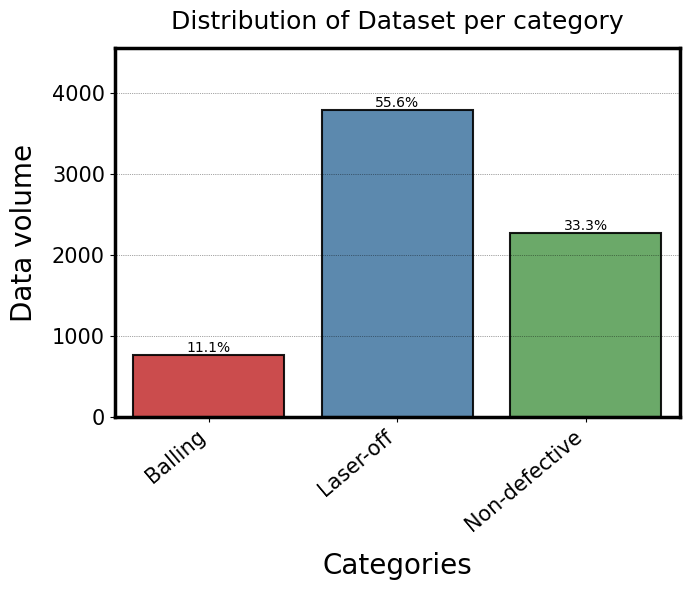

In [11]:
filename = 'dataset_distribution'
plot_data_distribution(df_audio_dataset, 'label_1', 
                       'Distribution of Dataset per category', filename)
save_fig(f"{filename}.png")

## Plotting $U_1$ (scalogram) and $S_1$ (scattering)

In [12]:
def plot_u1_s1(x, sr, u1, s1, scat1d_u1, scat1d, title=""):
    # Plot U1
    filter_freqs = [filter_["xi"] * sr for filter_ in scat1d_u1.psi1_f]
    u1 = scat1d_u1(x)
    u1 = u1[1:len(filter_freqs) + 1, :]
    #   print(f"U1 shape: {u1.shape}")
    plot_scalogram(torch.log1p(u1), sr=sr, y_coords=filter_freqs, title=f"U1 of {title}")

    # Plot S1
    filter_freqs = [filter_["xi"] * sr for filter_ in scat1d.psi1_f]
    s1 = scat1d(x)
    s1_max = s1.max()
    s1 = s1[:len(filter_freqs), :]
    #   print(f"S1 shape: {s1.shape}")
    plot_scalogram(torch.log1p(s1), sr=sr, y_coords=filter_freqs, hop_len=2**J, title=f"S1 of {title}")

    
def plot_s2(s2, sr, scat1d_o2, title, save_dir="img"):
    os.makedirs(save_dir, exist_ok=True)
    create_s2_gif(s2,
                  sr,
                  scat1d_o2.psi1_f,
                  scat1d_o2.psi2_f,
                  save_dir=save_dir,
                  save_name=title,
                  title_prefix=title,
                  use_vmax=True,
                  discard_empty=True,
                  fps=10,
                  hop_len=scat1d_o2.T)
    img = display_gif(f"{save_dir}/{title}.gif")
    return img


def display_gif(fpath):
    Image(url='...')  # external
    return Image(open(fpath, 'rb').read())  # local

## Listen to and visualize each type of sound

### Adjusting Scattering Parameters
To adjust the scattering parameters appropriately that fit the dataset:

1. Determine the appropriate $N$: 

First, calculate the number of samples in your audio files based on their duration and sample rate. In our case, audi signals are sampled at 44.1 kHz, the number of samples for 100 ms would be:
$ 𝑁 = 0.1 × 44100 = 4410 $  
 

2. Adjust $J$ and $T$: 

- Given the new value of $N$, you'll want to reduce $J$ so that the maximum scale of the transform does not exceed the length of your signal. 
- A rule of thumb is to ensure that **$2^J$ is much less than N**

- Set T: This parameter should also be set to a value that makes sense given the new N. Often, 
$T = 2^J$
  is a practical starting point.

In [13]:
# Constants
sr = 44100  # Sample rate
duration = 0.1  # Duration in seconds: Length of the signal to process
N = int(sr * duration) # Number of samples: int(sr * duration), 2*12
J = int(np.log2(N)) - 5  # Adjust J based on N, J is  Scale of scattering
Q = (8, 1)  # Adjust quality factor if necessary

In [14]:
2**12

4096

In [15]:
J

7

In [78]:
for label in np.unique(labels):
    print(label)
    sample = df_audio_dataset[df_audio_dataset['label_1'] == label].sample(n=1)
    sample

Balling
Laser-off
Non-defective


In [92]:
df_audio_dataset

,audio_name,image_name,experiment_number,label_1,label_2,label_3,rms_energy,amplitude_envelope_mean,amplitude_envelope_std,zero_crossing_rate,...,mfcc_8_mean,mfcc_8_std,mfcc_9_mean,mfcc_9_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std
0,Exp_17_1_10.wav,Exp_17_1_10.jpg,17_1,Non-defective,NaN,NaN,0.031746,0.038982,0.014304,0.064399,...,-1.955670,7.565694,6.784209,13.263989,-4.241771,7.623967,10.760045,6.365362,-4.255302,6.843529
1,Exp_17_1_9.wav,Exp_17_1_9.jpg,17_1,Non-defective,NaN,NaN,0.042696,0.046830,0.018378,0.048526,...,2.400870,8.425775,10.965203,9.471119,-3.135444,8.011312,13.603483,6.959040,-5.711248,7.241501
2,Exp_17_1_8.wav,Exp_17_1_8.jpg,17_1,Non-defective,NaN,NaN,0.035057,0.042734,0.011573,0.075737,...,1.150261,9.403788,14.162999,9.516252,-8.762444,7.957384,12.542859,4.588312,-11.905286,5.806112
3,Exp_17_1_7.wav,Exp_17_1_7.jpg,17_1,Non-defective,NaN,NaN,0.030621,0.034609,0.014976,0.087528,...,-1.952435,7.164872,11.940722,13.199364,-8.201095,7.420465,10.894137,8.839649,-8.552934,7.470698
4,Exp_17_1_6.wav,Exp_17_1_6.jpg,17_1,Non-defective,NaN,NaN,0.029938,0.039680,0.008860,0.091837,...,-2.629555,10.869521,10.822444,7.406270,-7.824436,7.594238,11.877039,7.440609,-7.672489,7.914073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6812,Exp_April_16_test_4_4.wav,Exp_April_16_test_4_4.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.012902,0.015071,0.005879,0.099093,...,2.168951,6.490287,1.928032,8.401035,-1.724736,10.288368,-0.060851,8.381465,-12.953316,5.754806
6813,Exp_April_16_test_4_1.wav,Exp_April_16_test_4_1.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.013222,0.015257,0.005407,0.084127,...,0.476796,9.227147,0.945553,7.366714,-1.322515,7.652929,-0.733449,5.396196,-14.786466,7.339162
6814,Exp_April_16_test_4_2.wav,Exp_April_16_test_4_2.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.012246,0.014805,0.005100,0.093878,...,-0.026498,7.503857,2.117017,7.400688,-2.097013,8.523264,0.141502,6.387466,-10.734591,8.097878
6815,Exp_April_16_test_4_3.wav,Exp_April_16_test_4_3.jpg,April_16_test_4,Laser-off,Shielding Gas-off,NaN,0.013367,0.016546,0.005384,0.087302,...,1.089101,6.276635,0.685349,5.679959,-5.039695,5.392179,-2.741401,4.763264,-13.847133,7.911690


In [94]:
# Initialize scattering transforms
scat1d_u1 = Scattering1D(shape=(N,), J=J, Q=Q, T=1) # U1
scat1d = Scattering1D(shape=(N, ), J=J, Q=Q, T=2**J) # S1
scat1d_o2 = Scattering1D(shape=(N,), J=10, Q=Q, T=2**10, out_type="dict")

# Process and visualize samples from each label
for label in np.unique(labels):
    sample_index = df_audio_dataset[df_audio_dataset['label_1'] == label].sample(n=1)
    print (sample_index)
    title = f"{df_audio_dataset['audio_name'].values[0]} - {label}"
    print(title)
    filepath = os.path.join(final_audio_directory, df_audio_dataset.iloc[sample, 0])
    
    # Load audio file and process
    x, sr = librosa.load(filepath, sr=None)
    x = torch.tensor(x[..., :N], dtype=torch.float32)
    
    print("computing U1")
    u1 = scat1d_u1(x)
    print("computing S1")
    s1 = scat1d(x)
    
    # Visualization function needs to be defined or adjusted if not provided
    print("plotting U1, S1")
    plot_u1_s1(x, sr, u1, s1, scat1d_u1, scat1d, title=title)
    plt.show()

    print("computing S2")
    s2 = scat1d_o2(x)
    print("plotting S2")
    plot_s2(s2, sr, scat1d_o2, title=title)

    print()

          audio_name       image_name experiment_number  label_1 label_2  \
406  Exp_18_22_4.wav  Exp_18_22_4.jpg             18_22  Balling     NaN   

    label_3  rms_energy  amplitude_envelope_mean  amplitude_envelope_std  \
406     NaN    0.041861                 0.050814                0.016467   

     zero_crossing_rate  ...  mfcc_8_mean  mfcc_8_std  mfcc_9_mean  \
406            0.065079  ...     0.913647     7.24476     13.85955   

     mfcc_9_std  mfcc_10_mean  mfcc_10_std  mfcc_11_mean  mfcc_11_std  \
406    9.787443     -3.666738     8.467115     11.709171     7.942098   

     mfcc_12_mean  mfcc_12_std  
406     -9.453233     5.778482  

[1 rows x 89 columns]
Exp_17_1_10.wav - Balling


IndexError: .iloc requires numeric indexers, got [['Exp_18_12_11.wav' 'Exp_18_12_11.jpg' '18_12' 'Balling' nan nan
  0.03821561112999916 0.04052891582250595 0.018493834882974625
  0.07913832366466522 0.0 -100.0 -36.457908630371094 4300.972367136102
  2083.4080506822806 1.5789473684210527 0.9902572485382515
  -0.7853506803512573 0.09384274482727051 -0.8556365966796875
  0.0740678608417511 -0.8462499380111694 0.06892475485801697
  -0.8537376523017883 0.05571836978197098 -0.849855899810791
  0.05472595617175102 -0.5760283470153809 0.1918330043554306
  -12.72110652923584 19.331899642944336 -13.516021728515625
  19.060522079467773 -14.184210777282715 18.8310489654541
  -14.438702583312988 18.741647720336914 -13.967190742492676
  18.903987884521484 -19.236766815185547 17.169231414794922
  -0.0038880234902822657 0.0020444130241437718 0.0054393489600012175
  0.006547505652624892 0.835184981948451 0.2940050028424367
  0.23357083668050013 0.26487181132897347 0.058299270801638305
  0.0382742790135379 1749.8560855263158 2875.3741357188264
  0.007578790776039425 0.02052830846448202 0.03800707996675843
  0.014415251826836591 0.7339881156620226 0.38155558817014873
  -0.7112250767256084 0.9372413050477693 33.57924461364746
  21.17103613951154 -792.4060668945312 162.55780029296875
  112.64186096191406 39.47767639160156 4.480086326599121
  11.734535217285156 67.31114959716797 26.160823822021484
  -34.03339385986328 16.28697967529297 46.993412017822266
  19.633169174194336 -4.454376220703125 8.183877944946289
  19.748987197875977 14.675405502319336 -7.8681640625 9.17694091796875
  14.758776664733887 10.385659217834473 -6.706489562988281
  8.247471809387207 8.032800674438477 6.061731338500977
  -10.18123722076416 7.034620761871338]]

In [17]:
help(plot_scalogram)

Help on function plot_scalogram in module s1dt.plot:

plot_scalogram(scalogram: torch.Tensor, sr: float, y_coords: List[float], title: str = 'scalogram', hop_len: int = 1, cmap: str = 'magma', vmax: Optional[float] = None, save_path: Optional[str] = None, x_label: str = 'Time (seconds)', y_label: str = 'Frequency (Hz)') -> None
    Plots a scalogram of the provided data.
    
    The scalogram is a visual representation of the wavelet transform of a signal over time.
    This function uses matplotlib and librosa to create the plot.
    
    Parameters:
        scalogram (T): The scalogram data to be plotted.
        sr (float): The sample rate of the audio signal.
        y_coords (List[float]): The y-coordinates for the scalogram plot.
        title (str, optional): The title of the plot. Defaults to "scalogram".
        hop_len (int, optional): The hop length for the time axis (or T). Defaults to 1.
        cmap (str, optional): The colormap to use for the plot. Defaults to "magma".


In [18]:
help(extract_s2_scalogram)

Help on function extract_s2_scalogram in module s1dt.plot:

extract_s2_scalogram(s_scat_1d: Dict[Tuple[int, int], torch.Tensor], sr: float, psi1_f_idx: int, psi2_f: List[Dict[str, Any]], pad: bool = True, is_jtfst: bool = False) -> (<class 'torch.Tensor'>, typing.List[float])
    Extracts a second-order scalogram from a dictionary of scattering coefficients.
    
    This function iterates over the dictionary `s_all` and collects the scattering coefficients corresponding to the provided `s1_idx`.
    If a coefficient is not found and `pad` is True, a tensor of zeros is added instead.
    The collected coefficients are then stacked into a tensor to form the scalogram.
    
    Parameters:
        s_scat_1d (Dict[Tuple[int, int], torch.Tensor]): A dictionary where the keys are tuples of indices and the values are scattering coefficients.
        sr: Sampling rate.
        psi1_f_idx (int): The index of the first-order scattering coefficient to extract.
        psi2_f (List[Dict[str, Any]

## Extracting the features

- We pre-extract the features offline: 
    - **CQT** with `nnAudio` and 
    - **time scatttering** / **JTFS** with `kymatio`.
- A numpy array per audio example will be saved into a feature folder.
- The resulting CQT has `XX` frequency bins and `XX` temporal frames. There's no lowpass filter applied across the CQT's temporal dimension.
- Time scattering and JTFS give us `X` temporal frames since our hop size is `2**J` `(2**7 / 2**12)`. 
- Time-shift invariance is a useful property, particularly for periodic modulations.
    - The larger we set `T` (default `2**J`), the more we impose invariance to time-shifts in both spectral shape and spectrotemporal modulations.
    
- Likewise, we can impose frequency transposition invariance with JTFS, by setting `F`, where transposition invariance is achieved over `Q / F` octaves.
- Periodic modulations are invariant to frequency transpositions. In accordance with common fate principles of auditory grouping, the harmonics produced by an instrument will follow congruent spectrotemporal modulation envelopes.

- We construct the `Scattering1D` filterbanks with a maximum scale of `J=12` (`# octaves`).
- We use 12 and 2 filters per octave in the first and second-order filterbanks respectively.
- we average over a temporal support of `2**J`.
- We construct the `TimeFrequencyScattering` temporal filterbanks with a maximum scale of `J=12` (`# octaves`).
- We use 12 and 2 filters per octave in the first and second-order temporal filterbanks respectively.
- We average over a temporal support of `2**J` and frequential support of `Q / F = 1` octave..
- The frequential filterbank has its own set of parameters.
- We use `J_fr=3` octaves, with `Q_fr = 2` filters per octave.

[Here is the feature extraction code.](https://github.com/cyrusvahidi/ismir23-kymatio-tools/blob/main/s1dt/data.py)

### Definitions and Parameter Explanations
#### 1. Scattering1D (scat1d):
Scattering1D uses wavelet transforms to create a robust representation of audio that captures both the amplitude and frequency modulations within a sound signal. It's especially useful for classification tasks because it provides `time-shift invariance` and some degree of `deformation stability`.
Parameters:
- **shape**: The length of the input signal. (e.g., 4410 samples)
- **Q**: Quality factor, determining the number of wavelets per octave. (consider reducing it if AM audio has less frequency variation than music.)
- **J**: The maximum scale of scattering, related to the number of octaves.
- **global_avg**: Whether to apply global averaging, affecting time-shift invariance.
        
#### 2. Joint Time-Frequency Scattering (JTFS):
JTFS extends Scattering1D by also considering the `modulation` across both time and frequency dimensions, enhancing its ability to capture the structure of audio signals.
Parameters:
- **J_fr**: Number of octaves for the frequency scattering.
- **Q_fr**: Quality factor for the frequency axis, i.e., filters per octave.
- **F**: The factor to impose frequency transposition invariance.
- **T**: Temporal support, influencing time-shift invariance. based on sound’s temporal dynamics

#### 2. Constant-Q Transform (CQT):
CQT provides a time-frequency representation where the frequency bins are geometrically spaced and have a constant Q-factor (quality factor). This is different from the traditional Fourier transform which has linearly spaced bins. CQT is particularly useful for music and complex sound analysis because it mimics human auditory perception.
Parameters:
- **n_bins**: Total number of bins across all octaves.
- **bins_per_octave**: Bins per octave. More bins per octave provide finer resolution
- **hop_length**: The number of samples between successive frames.

In [19]:
# Parameters used for feature extraction
features = {
    "scat1d": {
        "shape": (4410, ),
        "Q": (8, 2),
        "J": 8,
        "global_avg": False
    },
    "jtfs": {
        "shape": (4410, ),
        "Q": (8, 2),
        "J": 8,
        "J_fr": 3,
        "Q_fr": 2,
        "F": 12,
        "T": 2**7,
        "global_avg": False
    },
    "cqt": {
        "n_bins": 12,
        "bins_per_octave": 4,
        "hop_length": 256,
        "global_avg": False
    },
    "mfcc": {
        "n_mfcc": 40,
        "log_mels": True
    },
   
}

In [20]:
def extract_features(features, sol_dir="/home/chenlequn/pan1/Dataset/Laser-Wire-DED-ThermalAudio-Dataset/Dataset/audio", batch_size=16, device="cuda"):
    """
    Extracts features from audio files located in the specified directory.

    This function uses two types of feature extraction methods: scat1d and jtfs. 
    The extracted features are then saved for further use.

    Parameters:
    sol_dir (str): The directory where the audio files are located. 
                   Default is "/import/c4dm-datasets/SOL_0.9_HQ-PMT/".
    batch_size (int): The number of audio files to be processed at a time. Default is 16.
    device (str): The device to use for computations. Default is "cuda" for GPU usage.
    """
    
    for feature_id, feature_kwargs in features.items():
        extractor = FeatureExtractorSOL(sol_dir, device=device, batch_size=batch_size, feature_id=feature_id, in_shape=4410, **feature_kwargs)
        extractor.extract()
        extractor.save_features()
        extractor.save_stats()

In [21]:
extract_features(features, sol_dir = final_audio_directory, batch_size=16) 

Loading audio ...


100%|████████████████████████████████████| 7686/7686 [00:00<00:00, 40169.59it/s]


Extracting features ...


100%|██████████████████████████████████| 7686/7686 [00:00<00:00, 1008522.46it/s]


Loading audio ...


100%|████████████████████████████████████| 7686/7686 [00:00<00:00, 41342.48it/s]


Extracting features ...


100%|██████████████████████████████████| 7686/7686 [00:00<00:00, 1072293.13it/s]


CQT kernels created, time used = 0.0028 seconds
Loading audio ...


100%|████████████████████████████████████| 7686/7686 [00:00<00:00, 41592.49it/s]


Extracting features ...


100%|██████████████████████████████████| 7686/7686 [00:00<00:00, 1042776.02it/s]
/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Loading audio ...


100%|████████████████████████████████████| 7686/7686 [00:00<00:00, 42511.13it/s]


Extracting features ...


100%|██████████████████████████████████| 7686/7686 [00:00<00:00, 1021367.44it/s]


## Define the dataset
- load precomputed features extracted with the specified transformation

In [29]:
class SOLPMT(Dataset):
    def __init__(self, annotation_df, audio_directory, feature="jtfs"):
        self.annotations = annotation_df
        self.audio_directory = audio_directory
        self.feature = feature
        self.class_to_idx = {
            'Balling': 0,
            'Non-defective': 1,
            'Laser-off': 2,
        }

    def __getitem__(self, index):
        # Get the .wav file name from the first column, and replace it from .wave format to the numpy format
        x = np.load(os.path.join(self.audio_directory, self.feature, self.annotations.iloc[index, 0].replace(".wav", ".npy"))) 
        y = self._get_sample_label(index)
        return x, y
    
    
    def _get_sample_label(self, index):
        class_name = self.annotations.iloc[index, 3]  # Get the class label from the fourth column
        return self.class_to_idx[class_name]

    def __len__(self):
        return len(self.annotations)

## Setup the dataloaders

We use the existing training, validation, test data split from the provided metadata CSV

In [26]:
%store -r train_indices
%store -r val_indices
%store -r test_indices

In [30]:
# Create train, val, and test datasets for deep learning models
train_annotations_df = df_audio_dataset.iloc[train_indices, :]
val_annotations_df = df_audio_dataset.iloc[val_indices, :]
test_annotations_df = df_audio_dataset.iloc[test_indices, :]

In [43]:
class SOLPMTDataModule(pl.LightningDataModule):
    def __init__(self, 
                 train_annotations_df,
                 val_annotations_df,
                 test_annotations_df,
                 audio_directory,
                 batch_size: float = 1, 
                 num_workers: float = 4,
                 feature: str = "jtfs"):
        super().__init__()
        
        self.train_annotations_df = train_annotations_df
        self.val_annotations_df = val_annotations_df
        self.test_annotations_df = test_annotations_df
        self.audio_directory = audio_directory
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.feature = feature
        
        
    def setup(self, stage=None):
        self.train_ds = SOLPMT(self.train_annotations_df, self.audio_directory, feature=self.feature)
        self.test_ds = SOLPMT(self.test_annotations_df, self.audio_directory, feature=self.feature)
        self.val_ds = SOLPMT(self.val_annotations_df, self.audio_directory, feature=self.feature)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_ds,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
        )


### Inspecting the precomputed features
- The scattering features per sample are organised by `(path, time)`.
- First and second order scattering coefficients computed and concatenated to form a sequence across time.

In [44]:
datamodule = SOLPMTDataModule(train_annotations_df, val_annotations_df, test_annotations_df, final_audio_directory, batch_size=32, feature="jtfs")
datamodule.setup()
feature_shape = datamodule.train_ds[1][0].shape
print(feature_shape)
in_channels = feature_shape[0]

(972, 35)


## Training pipeline
- We optimize a 1D convnet for multiclass classification across 5 classes: balling, laser-off, non-defective
- Use the cross-entropy loss over 5 classes, and report multiclass classification accuracy.
- pick the best model state for testing according to the best monitored validation accuracy.
- We use the Adam optimizer with a learning rate of `1e-3`.

In [52]:
# df_audio_dataset.sort_values(by='label_1')["label_1"].tolist()

In [53]:
from typing import Any, Dict, Tuple

import torch, numpy as np
from lightning import LightningModule

from torchmetrics import MaxMetric, MeanMetric, ClasswiseWrapper
from torchmetrics.classification.accuracy import Accuracy


class LitModule(LightningModule):
    def __init__(self,
                 net: torch.nn.Module,
                 lr: float = 1e-3,
                 compile: bool = False,
                 num_classes=3,
                 labels = df_audio_dataset.sort_values(by='label_1')["label_1"].tolist() 
                )-> None:
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)

        self.net = net
        self.lr = lr

        # loss function
        self.criterion = torch.nn.CrossEntropyLoss()

        # metric objects for calculating and averaging accuracy across batches
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)

        # for averaging loss across batches
        self.train_loss = MeanMetric()
        self.val_loss = MeanMetric()
        self.test_loss = MeanMetric()

        self.classwise_acc = ClasswiseWrapper(Accuracy(task="multiclass", num_classes=num_classes), labels=labels)

        # for tracking best so far validation accuracy
        self.val_acc_best = MaxMetric()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Perform a forward pass through the model `self.net`.

        :param x: A tensor of (batch, path, time).
        :return: A tensor of logits.
        """
        return self.net(x)

    def on_train_start(self) -> None:
        """Lightning hook that is called when training begins."""
        # by default lightning executes validation step sanity checks before training starts,
        # so it's worth to make sure validation metrics don't store results from these checks
        self.val_loss.reset()
        self.val_acc.reset()
        self.val_acc_best.reset()

    def model_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Perform a single model step on a batch of data.

        :param batch: A batch of data (a tuple) containing the input tensor of images and target labels.

        :return: A tuple containing (in order):
            - A tensor of losses.
            - A tensor of predictions.
            - A tensor of target labels.
        """
        x, y = batch
        logits = self.forward(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, y

    def training_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        """Perform a single training step on a batch of data from the training set.

        :param batch: A batch of data (a tuple) containing the input tensor of images and target
            labels.
        :param batch_idx: The index of the current batch.
        :return: A tensor of losses between model predictions and targets.
        """
        loss, preds, targets = self.model_step(batch)

        # update and log metrics
        self.train_loss(loss)
        self.train_acc(preds, targets)
        self.log(
            "train/loss", self.train_loss, on_step=False, on_epoch=True, prog_bar=True
        )
        self.log(
            "train/acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True
        )
        # return loss or backpropagation will fail
        return loss

    def on_train_epoch_end(self) -> None:
        "Lightning hook that is called when a training epoch ends."
        pass

    def validation_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        """Perform a single validation step on a batch of data from the validation set.

        :param batch: A batch of data (a tuple) containing the input tensor of images and target
            labels.
        :param batch_idx: The index of the current batch.
        """
        loss, preds, targets = self.model_step(batch)

        # update and log metrics
        self.val_loss(loss)
        self.val_acc(preds, targets)
        self.log("val/loss", self.val_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val/acc", self.val_acc, on_step=True, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self) -> None:
        "Lightning hook that is called when a validation epoch ends."
        acc = self.val_acc.compute()  # get current val acc
        self.val_acc_best(acc)  # update best so far val acc
        # log `val_acc_best` as a value through `.compute()` method, instead of as a metric object
        # otherwise metric would be reset by lightning after each epoch
        self.log(
            "val/acc_best", self.val_acc_best.compute(), sync_dist=True, prog_bar=True
        )

    def test_step(
        self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        """Perform a single test step on a batch of data from the test set.

        :param batch: A batch of data (a tuple) containing the input tensor of images and target
            labels.
        :param batch_idx: The index of the current batch.
        """
        loss, preds, targets = self.model_step(batch)

        # update and log metrics
        self.test_loss(loss)
        self.test_acc(preds, targets)
        self.log(
            "test/loss", self.test_loss, on_step=False, on_epoch=True, prog_bar=True
        )
        self.log("test/acc", self.test_acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_test_epoch_end(self) -> None:
        """Lightning hook that is called when a test epoch ends."""
        pass

    def setup(self, stage: str) -> None:
        """Lightning hook that is called at the beginning of fit (train + validate), validate,
        test, or predict.

        This is a good hook when you need to build models dynamically or adjust something about
        them. This hook is called on every process when using DDP.

        :param stage: Either `"fit"`, `"validate"`, `"test"`, or `"predict"`.
        """
        if self.hparams.compile and stage == "fit":
            self.net = torch.compile(self.net)

    def configure_optimizers(self) -> Dict[str, Any]:
        """Choose what optimizers and learning-rate schedulers to use in your optimization.
        Normally you'd need one. But in the case of GANs or similar you might have multiple.

        Examples:
            https://lightning.ai/docs/pytorch/latest/common/lightning_module.html#configure-optimizers

        :return: A dict containing the configured optimizers and learning-rate schedulers to be used for training.
        """
        optimizer = optimizer = torch.optim.Adam(params=self.trainer.model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.5, patience=10)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val/loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

### Defining the 1D convnet

- We implement a simple 1D convnet.
- the scattering paths (first and second-order) are concatenated
- For each path (channel), we do convolution over time, and sum each filter's activations across the incoming paths.
- At the end of the convolutional feature extractor, we use a global average pooling layer, prior to a simple classification head with two linear layers separated by a ReLU nonlinearity.

In [54]:
import math
import torch.nn as nn


class SimpleConvNet1d(nn.Module):
    def __init__(self, in_channels, num_classes=3, dense_dim=64, dropout_rate=0.5):
        super().__init__()

        # c_ref = in_channels
        # scale_factor = (1024 // in_channels)
        # ckw = dict(stride=1, bias=False, padding='same')
        # C0 = (c_ref//2) * scale_factor
        # C1 = c_ref * scale_factor
        # C2 = 2*c_ref*scale_factor

        # dense_dim = (dense_dim) // math.ceil(1024 / in_channels)

        c_ref = in_channels // 4
        ckw = dict(stride=1, bias=False, padding='same')
        C0, C1, C2 = c_ref//2, c_ref, 2*c_ref

        self.conv_features = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=C0, kernel_size=7, **ckw),
            nn.BatchNorm1d(C0),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=C0, out_channels=C1, kernel_size=5, **ckw),
            nn.BatchNorm1d(C1),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=C1, out_channels=C2, kernel_size=3, **ckw),
            nn.BatchNorm1d(C2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=1)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features=C2, out_features=dense_dim),
            nn.ReLU(),
            nn.Linear(in_features=dense_dim, out_features=num_classes)
        )

    def forward(self, x):
        z = self.conv_features(x).squeeze(dim=-1)
        logits = self.classifier(z)
        return logits

In [60]:
#@title Choose an acoustic representation input
feature = "jtfs" # @param ["jtfs", "scat1d", "cqt", "mfcc"]

datamodule = SOLPMTDataModule(train_annotations_df, val_annotations_df, test_annotations_df, final_audio_directory, batch_size=32, feature=feature)
datamodule.setup()
feature_shape = datamodule.train_ds[1][0].shape
print(f"Input feature shape: {feature_shape}")
in_channels = feature_shape[0]

Input feature shape: (972, 35)


## Training and evaluation

- We optimize for 5 epochs with a batch size of 32.
- the first epoch could be slow due to loading data 
- Interestingly, this is sufficient to achieve high classification accuracy on the test set for both `Scattering1D` and `TimeFrequencyScattering` input features
- Importantly, `time-frequency scattering` is capable of capturing cross-frequency channel dependencies, while second-order time scattering analyses each frequency path independently.
- Because of this, time scattering is limited in its ability to analyse amplitude modulations in signals with nonstationary frequency.

- the number of input channels for the CQT is 100x. However, the literature also suggests that scattering features are superior than simply short-time spectral features for timbre and playing technique classification.
We tested a CQT model with the same order of parameters as the scattering models. It made no difference to the test accuracy.


In [65]:
from lightning import Trainer

net = SimpleConvNet1d(in_channels)
model = LitModule(net=net)

trainer = Trainer(accelerator="gpu" if torch.cuda.is_available() else "cpu", min_epochs=0, max_epochs=10)

trainer.fit(model=model, datamodule=datamodule)
train_metrics = trainer.callback_metrics
trainer.test(model=model, datamodule=datamodule)
test_metrics = trainer.callback_metrics

metric_dict = {**train_metrics, **test_metrics}

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | net           | SimpleConvNet1d    | 1.4 M 
1 | criterion     | CrossEntropyLoss   | 0     
2 | train_acc     | MulticlassAccuracy | 0     
3 | val_acc       | MulticlassAccuracy | 0     
4 | test_acc      | MulticlassAccuracy | 0     
5 | train_loss    | MeanMetric         | 0     
6 | val_loss      | MeanMetric         | 0     
7 | test_loss     | MeanMetric         | 0     
8 | classwise_acc | ClasswiseWrapper   | 0     
9 | val_acc_best  | MaxMetric          | 0     
-----------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.431     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9032257795333862     │
│         test/loss         │     0.280549556016922     │
└───────────────────────────┴───────────────────────────┘

In [66]:
# @title Inspecting success/failure cases
model.eval()

test_ds = datamodule.test_ds

incorrect = []
y_true, y_pred = [], []
for i, (x, y) in enumerate(test_ds):
    logits = model(torch.tensor(x[None, ...])) # get logits for test example
    preds = torch.argmax(logits, dim=1) # get predicted label
    if preds != y:
        # save the metadata if the prediction is incorrect
        incorrect.append(dict(test_ds.annotations.iloc[i]))
    y_true.append(int(y))
    y_pred.append(int(preds))

In [80]:
# labels

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (6817).

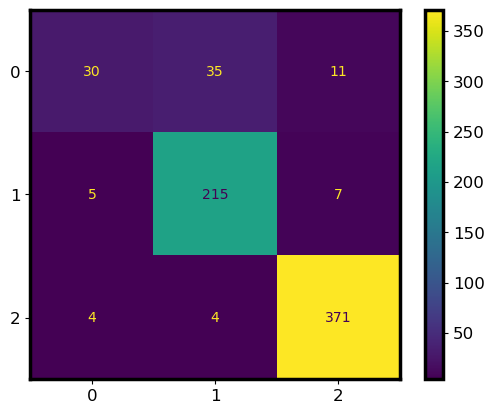

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
np.save(f"confusion_{feature}", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
disp.plot()
plt.xticks(rotation=45)

computing U1
computing S1


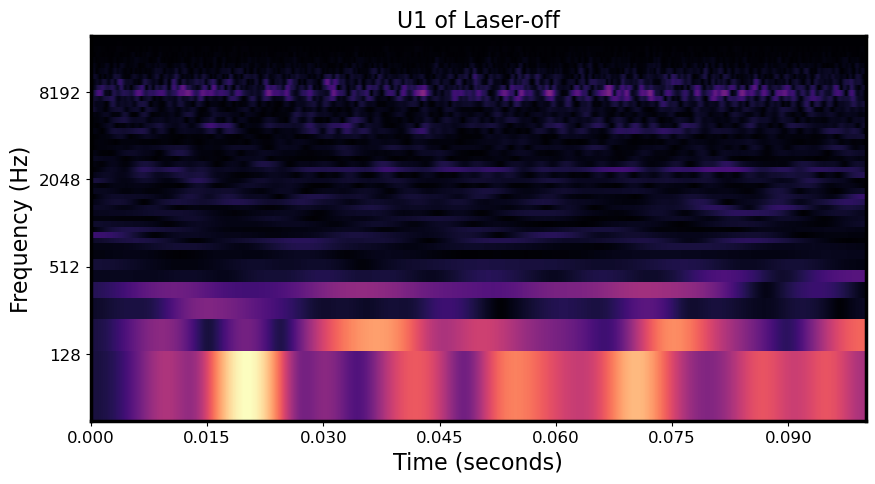

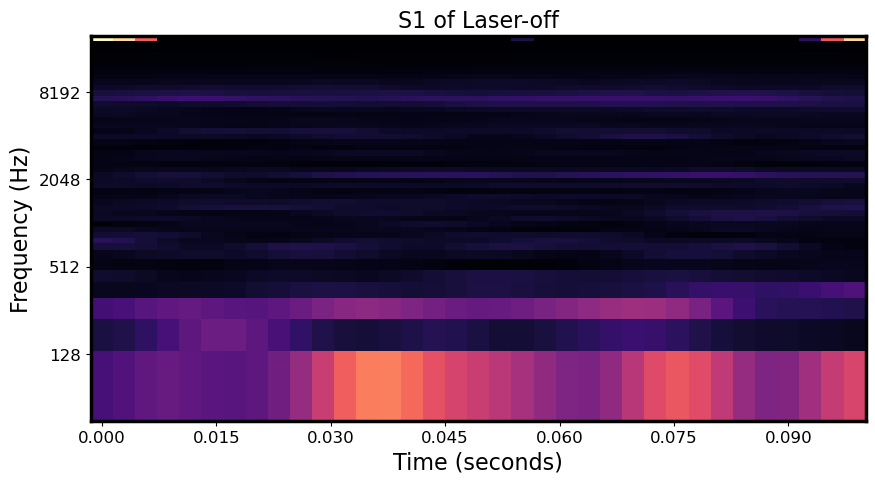

In [109]:
# @title Visualize a failed prediction
sample_idx = 1 #@param {type:"slider", min:0, max:1000, step:1.0}

sample = incorrect[sample_idx]
filepath = os.path.join(final_audio_directory, sample['audio_name'])

# Load audio file and process
x, sr = librosa.load(filepath, sr=None)
x = torch.tensor(x[..., :N], dtype=torch.float32)

print("computing U1")
u1 = scat1d_u1(x)
print("computing S1")
s1 = scat1d(x)

display(Audio(filepath))
plot_u1_s1(x, sr, u1, s1, scat1d_u1, scat1d, title=f"{sample['label_1']}")